# Mobile Customer Churn

In this Portfolio task you will work with some (fake but realistic) data on Mobile Customer Churn.  Churn is where
a customer leaves the mobile provider.   The goal is to build a simple predictive model to predict churn from available features. 

The data was generated (by Hume Winzar at Macquarie) based on a real dataset provided by Optus.  The data is simulated but the column headings are the same. (Note that I'm not sure if all of the real relationships in this data are preserved so you need to be cautious in interpreting the results of your analysis here).  

The data is provided in file `MobileCustomerChurn.csv` and column headings are defined in a file `MobileChurnDataDictionary.csv` (store these in the `files` folder in your project).

Your high level goal in this notebook is to try to build and evaluate a __predictive model for churn__ - predict the value of the CHURN_IND field in the data from some of the other fields.  Note that the three `RECON` fields should not be used as they indicate whether the customer reconnected after having churned. 

__Note:__ you are not being evaluated on the _accuracy_ of the model but on the _process_ that you use to generate it.  You can use a simple model such as Logistic Regression for this task or try one of the more advanced methods covered in recent weeks.  Explore the data, build a model using a selection of features and then do some work on finding out which features provide the most accurate results.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE
from sklearn.metrics import plot_confusion_matrix

In [2]:
churn = pd.read_csv("files/MobileCustomerChurn.csv", na_values=["NA", "#VALUE!"], index_col='INDEX')
churn.head()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,...,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
INDEX,,,,,,,,,,,,,,,,,,,,,
1,1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,...,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA,NaN,NaN,NaN
2,2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,...,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW,NaN,NaN,NaN
3,5,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,...,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA,NaN,NaN,NaN
4,6,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,...,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC,NaN,NaN,NaN
5,8,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,...,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW,NaN,NaN,NaN


## Data Cleaning an Exploration:

In [3]:
# the number of row and column in the dataset
churn.shape

(46206, 21)

We check if the dataset has any missing values to deal with.

In [4]:
churn.isna().sum()

CUST_ID                             0
ACCOUNT_TENURE                      0
ACCT_CNT_SERVICES                   0
AGE                                76
CFU                                 0
SERVICE_TENURE                      0
PLAN_ACCESS_FEE                     0
BYO_PLAN_STATUS                     0
PLAN_TENURE                         0
MONTHS_OF_CONTRACT_REMAINING        0
LAST_FX_CONTRACT_DURATION           0
CONTRACT_STATUS                     0
PREV_CONTRACT_DURATION              0
HANDSET_USED_BRAND                  0
CHURN_IND                           0
MONTHLY_SPEND                       0
COUNTRY_METRO_REGION                1
STATE                               1
RECON_SMS_NEXT_MTH              17790
RECON_TELE_NEXT_MTH             17790
RECON_EMAIL_NEXT_MTH            17790
dtype: int64

**Comment:** There are 17790 values missing in the three `RECON` columns, which might be considered as large number of missing values. However, since the three `RECON` fields will not be used in building the model even if they are numerical fields, we will drop these fields instead of dropping the rows of data. If we drops the NaN rows, our dataset will be affected significantly as the rows of missing values in the three `RECON` fields are approximately one-third of the total rows (46206 rows) of the dataset. Also, we cannot decide whether a customer will recontract next month. Thus, we will not fill in a value for these fields. Similarly, we will drops the rows of missing values in `AGE`, `COUNTRY_METRO_REGION`, and `STATE`, as we cannot fill the values by guessing where the customers from (Region or the City, and State) and their ages. Compared to the `RECON` fields, the missing values in `AGE`, `COUNTRY_METRO_REGION`, and `STATE` sumup to 78 rows, which could be considered as a small number of data rows in the large dataset (78/46206 rows). Therefore, removing these rows will not affect significantly on the dataset.

In [5]:
#drop three 'RECON' fields
cleaned_churn = churn.drop(["RECON_SMS_NEXT_MTH", "RECON_TELE_NEXT_MTH", 
                            "RECON_EMAIL_NEXT_MTH"], axis= 1)

# drop other missing values data rows
cleaned_churn.dropna(inplace= True)

In [6]:
# Summary of the dataset
cleaned_churn.describe()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,CHURN_IND,MONTHLY_SPEND
count,46129.000000,46129.000000,46129.000000,46129.000000,46129.000000,46129.000000,46129.000000,46129.000000,46129.000000,46129.000000,46129.000000,46129.000000
mean,42338.001344,45.887229,1.554402,41.411607,50.364413,51.360367,10.851157,8.234733,20.350755,15.253051,0.385072,75.167410
std,22102.853209,33.073285,0.834352,15.263812,51.942875,20.854578,9.772148,8.339838,8.033236,10.981640,0.486618,73.392728
min,1.000000,0.000000,1.000000,-4.000000,0.000000,8.180000,0.000000,0.000000,0.000000,0.000000,0.000000,1.020000
25%,24951.000000,14.000000,1.000000,28.000000,11.000000,36.360000,3.000000,0.000000,24.000000,0.000000,0.000000,36.360000
50%,43264.000000,44.000000,1.000000,40.000000,35.000000,54.540000,8.000000,7.000000,24.000000,24.000000,0.000000,54.540000
75%,61141.000000,77.000000,2.000000,52.000000,69.000000,72.720000,16.000000,16.000000,24.000000,24.000000,1.000000,84.530000
max,79500.000000,120.000000,4.000000,116.000000,259.000000,234.540000,147.000000,24.000000,36.000000,36.000000,1.000000,1965.890000


**Comment:** The minimum age of account holders is -4; this might be an inaccurate record which should be discarded as outlier (we assume the dataset does not hold those holders which have not been born yet).

In [7]:
# drop data rows that have ages are negative or 0
cleaned_churn.drop(cleaned_churn.index[cleaned_churn["AGE"] <= 0], inplace= True)

### Exploration:

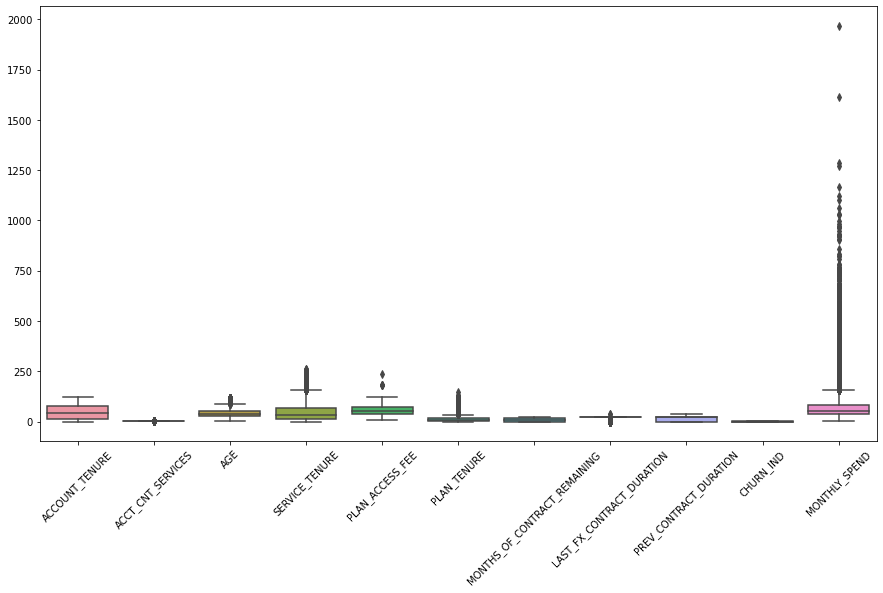

In [8]:
# plot the distribution of the numerical data
plt.subplots(figsize=(15,8))
df_plot = cleaned_churn.drop(["CUST_ID"], axis=1)
plot = sns.boxplot(data=df_plot)
plot.set_xticklabels(plot.get_xticklabels(),rotation = 45)
plt.show()

**Interpretation:** The `MONTHLY_SPEND` varies the most which there are several outliers distributed over the upper whisker. By contrast, the data in the `ACCOUNT_TENURE`, `MONTHS_OF_CONTRACT_REMAINING`, `PREV_CONTRACT_DURATION` fields is distributed around the mean and has no outlier outside  the range.

In [9]:
# check the size of the dataset again
cleaned_churn.shape

(46127, 18)

In [10]:
# counts the value of the classes in the CHURN_IND
cleaned_churn["CHURN_IND"].value_counts()

0    28365
1    17762
Name: CHURN_IND, dtype: int64

<AxesSubplot:xlabel='CHURN_IND', ylabel='count'>

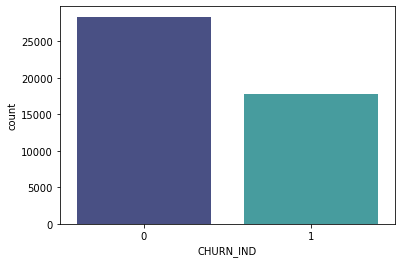

In [11]:
sns.countplot(x="CHURN_IND", data=cleaned_churn, palette="mako")

**Comment:** The number of class 0 is considerably larger than the number of class 1. Class 0 accounts for 61.5% of the dataset while the class 1 accounts for 38.5%. Thus, the samples are imbalanced.

***Compare the average of the numerical fields between two classes in CHURN_IND***

In [12]:
churn_mean= cleaned_churn.groupby("CHURN_IND").mean()
churn_mean.drop(["CUST_ID"], axis=1, inplace= True)
churn_mean

,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,MONTHLY_SPEND
CHURN_IND,,,,,,,,,,
0,49.860074,1.595593,42.805288,56.687150,51.965485,9.754909,9.867372,20.774194,15.810048,64.23257
1,39.541831,1.488684,39.191082,40.266862,50.396277,12.601115,5.628420,19.675487,14.363923,92.63415


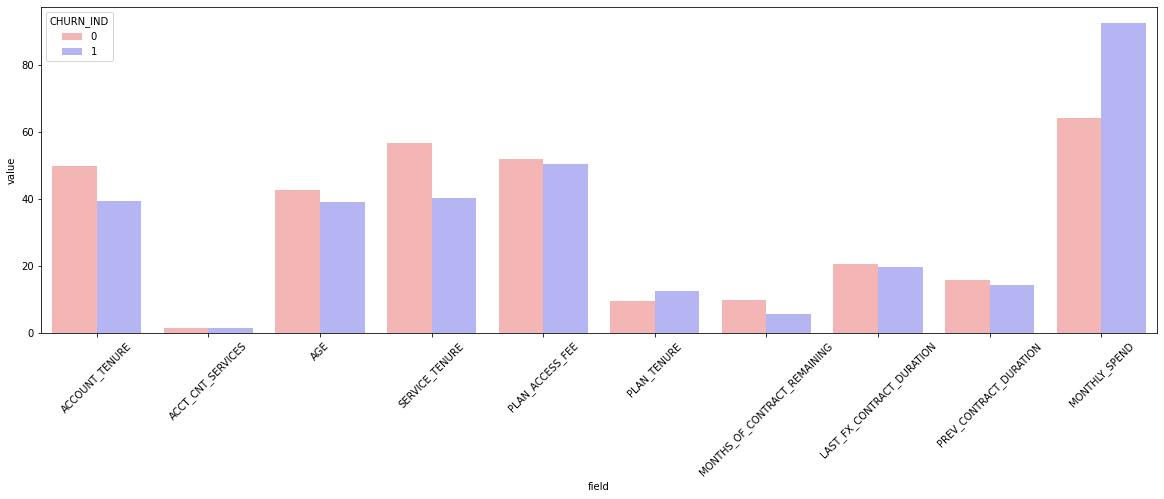

In [13]:
# plotting the mean of these fields to compare
churn_mean["CHURN_IND"] = churn_mean.index
melted_mean = pd.melt(churn_mean,
                      id_vars = ["CHURN_IND"],
                      var_name = "field")

plt.subplots(figsize=(20,6))
melted_plot = sns.barplot(x="field", y="value", hue="CHURN_IND", data=melted_mean, palette="bwr_r")
melted_plot.set_xticklabels(melted_plot.get_xticklabels(),rotation = 45)
plt.show()

**Interpretation:** 
* `ACCOUNT_TENURE`, `SERVICE_TENURE`: The tenure in months for account and service of customers who still connect to Optus is longer than customers who have disconnected the service.
* `ACCT_CNT_SEVICES`: If we round the two means, we could observe that the average number of services are the same in both "connected" and "disconnected" customers. Thus, this field might not be a good predictor for churn.
* `AGE`: Customers who left the service tend to be younger than customers who still use the service.
* `PLAN_ACCESS_FEE`: The monthly access fee of "connected" customers are higher than the customers who churned.
* `PLAN_TENURE`: The tenure in months for plan is longer for churned customers compared to the customers who still connect the service.
* `MONTHS_OF_CONTRACT_REMAINING`, `LAST_FX_CONTRACT_DURATION`, `PREV_CONTRACT_DURATION`: customers with class 0 in `CHURN_IND` has higher average than the customers who churned.
* `MONTHLY_SPEND`: The monthly service spend of customer who left the service is significantly higher than the customer who still use the service.

***Selection of categorical variables in the dataset***

Since the variables (fields) we use to predict CHURN_IND are not only numerical, some of them are categorical, we should observe to select which categorical variables could be a good predictor for CHURN_IND before turning them into dummy variables (avoid long list of fields).

**Assumption:** `STATE`, and `HANDSET_USED_BRAND` might not be strong predictors since they cannot determine whether the customers will churn the service based on which state they live, and the device branch (we cannot predict the "churned" customer based on which branch has more Optus users).

In [14]:
# turn the selected categorical data into dummies
cleaned_churn.drop(["STATE", "HANDSET_USED_BRAND"], axis= 1, inplace=True)

dummy_churn = pd.get_dummies(cleaned_churn, 
                             columns= ["CFU", "BYO_PLAN_STATUS", "CONTRACT_STATUS", "COUNTRY_METRO_REGION"])

In [15]:
dummy_churn.head(2)

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,...,MONTHLY_SPEND,CFU_CONSUMER,CFU_SMALL BUSINESS,BYO_PLAN_STATUS_BYO,BYO_PLAN_STATUS_NON BYO,CONTRACT_STATUS_NO-CONTRACT,CONTRACT_STATUS_OFF-CONTRACT,CONTRACT_STATUS_ON-CONTRACT,COUNTRY_METRO_REGION_COUNTRY,COUNTRY_METRO_REGION_METRO
INDEX,,,,,,,,,,,,,,,,,,,,,
1,1,46,1,30.0,46,54.54,15,0,24,24,...,61.40,1,0,0,1,0,1,0,1,0
2,2,60,3,55.0,59,54.54,5,0,24,24,...,54.54,1,0,0,1,0,1,0,0,1


In [16]:
# check the shape of the dummy dataframe
dummy_churn.shape

(46127, 21)

## Model of Churn Prediction based on Numerical Fields:

### Model Building:

Since the logistic regression model could only take numerical input. Therefore, we first try to predict the churn based on all the numerical fields in the dataset.

In [17]:
# Split data into training(80%) and testing data (20%)
num_train, num_test = train_test_split(cleaned_churn, test_size=0.2, random_state=142)
print(num_train.shape)
print(num_test.shape)

(36901, 16)
(9226, 16)


In [18]:
X_num_train = num_train.drop(["CHURN_IND", "CUST_ID", "CFU", "BYO_PLAN_STATUS", 
                              "CONTRACT_STATUS","COUNTRY_METRO_REGION"], axis=1)
y_num_train = num_train["CHURN_IND"]
X_num_test = num_test.drop(["CHURN_IND", "CUST_ID", "CFU", "BYO_PLAN_STATUS", 
                            "CONTRACT_STATUS", "COUNTRY_METRO_REGION"], axis=1)
y_num_test = num_test["CHURN_IND"]

We input the independent and the dependent values to predict into the train and test variables. However, for the independent values (i.e. X_train, X_test), we do not include CUST_ID as it is just an identifier for a customer, which does not help to predict the the churn.

In [19]:
# fit the model
reg = LogisticRegression()
reg.fit(X_num_train, y_num_train)

LogisticRegression()

In [20]:
# predict train and test sets
num_train_preds = reg.predict(X_num_train)
num_test_preds = reg.predict(X_num_test)

### Evaluation:

In [21]:
# check the accuracy of the model
print("Train accuracy (numerical):")
print(accuracy_score(y_num_train, num_train_preds))

print("Test accuracy (numerical):")
print(accuracy_score(y_num_test, num_test_preds))

Train accuracy (numerical):
0.7110647407929325
Test accuracy (numerical):
0.7003034901365706


**Comment:** The accuracy score at around 0.7 (approximately 70% of the data was predicted correctly) indicates that the model was built not so well (as there is a considerable gap between 0.7 and 1). Additionally, there is a small gap of the accuracy scores of the train set and the test set. Thus, the model is not overfitting.

In [22]:
# check the confusion matrix of the model
confusion_matrix(y_num_test, num_test_preds)

array([[4580, 1031],
       [1734, 1881]], dtype=int64)

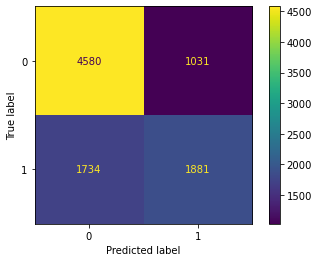

In [23]:
# plot the confusion matrix of the model
plot_confusion_matrix(reg, X_num_test, y_num_test)

**Interpretation:** There are 4580 correct predictions of the class 0 for churn; however, the false predictions of the class 0 is also significantly high which is up to 1031 reports. The number of the accurate class 1 values for churn is around 1881, while the false positive (inaccurate class 1 prediction in this case) is up to 1734 reports which is nearly the same as the true positive. Therefore, this model might not predict the class 1 for the churn precisely since the high false positive value, which might mislead the process of predicting the number of customers who might disconnect the service.

### Feature Selection:

We will select the number of features from one to the total columns (fields) of the train set, then we calculate the accuracy score for each of the choices of features. As such, we could find the highest accuracy score to determine how many features could build the better model than the original one.

In [24]:
# check the column in the train set
X_num_train.shape

(36901, 10)

In [25]:
# list for containing all the accuracy score
test_acc_scores = []

print("The accuracy score of the model (numerical):")
for i in range(1, 11):
    # build and fit the model
    lr = LogisticRegression(max_iter = 1000)
    rfe = RFE(estimator = lr, n_features_to_select = i, step = 1)
    rfe.fit(X_num_train, y_num_train)
    # predict based on test set
    preds = rfe.predict(X_num_test)
    # calculate accuracy score and append to the list
    acc_score = accuracy_score(y_num_test, preds)
    test_acc_scores.append(acc_score)
    # print the number of features with the accuracy score
    print("- with selection of", i, "features: ", acc_score)

The accuracy score of the model (numerical):
- with selection of 1 features:  0.6375460654671581
- with selection of 2 features:  0.6546715803164969
- with selection of 3 features:  0.6553219163234337
- with selection of 4 features:  0.658031649685671
- with selection of 5 features:  0.6999783221331021
- with selection of 6 features:  0.6978105354433124
- with selection of 7 features:  0.6985692607847388
- with selection of 8 features:  0.6969434207673965
- with selection of 9 features:  0.6969434207673965
- with selection of 10 features:  0.7003034901365706


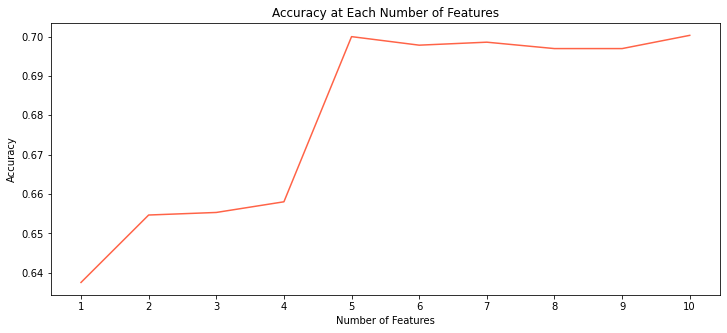

In [26]:
# Plotting the accuracy number
plt.figure(figsize=(12,5))
plotting = plt.plot(range(1, X_num_train.shape[1]+1), test_acc_scores, color= "tomato")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.title("Accuracy at Each Number of Features")
plt.xticks(np.arange(1, 11, step=1))
plt.show()

**Interpretation:** We could see the accuracy score of five-features model is nearly as high as (not much different from) the ten-features model (0.69998 compared to 0.70030). Therefore, we could build this "numerical only" model based on the five most important features instead of choosing all of the ten features to build.

In [27]:
# re-build the model by selecting five features
five_lr = LogisticRegression(max_iter = 1000)
five_rfe = RFE(estimator = five_lr, n_features_to_select = 5, step = 1)
five_rfe.fit(X_num_train, y_num_train)

RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=5)

In [28]:
# check which five features have been selected
X_num_train.columns[five_rfe.support_]

Index(['ACCOUNT_TENURE', 'AGE', 'MONTHS_OF_CONTRACT_REMAINING',
       'LAST_FX_CONTRACT_DURATION', 'MONTHLY_SPEND'],
      dtype='object')

**Comment:** the five features could be selected to build a better model include `ACCOUNT_TENURE`, `AGE`, `MONTHS_OF_CONTRACT_REMAINING`,
       `LAST_FX_CONTRACT_DURATION`, `MONTHLY_SPEND`.

## Model of Churn Prediction based on Selected Fields:

This model will be different from the previous model, which will apply both numerical and categorical fields to predict the churn.

### Model Building:

In [29]:
# Split data into training(80%) and testing data (20%)
train, test = train_test_split(dummy_churn, test_size=0.2, random_state=142)
print(train.shape)
print(test.shape)

(36901, 21)
(9226, 21)


In [30]:
X_train = train.drop(["CHURN_IND", "CUST_ID"], axis=1)
y_train = train["CHURN_IND"]
X_test = test.drop(["CHURN_IND", "CUST_ID"], axis=1)
y_test = test["CHURN_IND"]

In [31]:
# fit the model
reg_model = LogisticRegression(max_iter=1000)
reg_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [32]:
# predict train and test sets
train_preds = reg_model.predict(X_train)
test_preds = reg_model.predict(X_test)

### Evaluation:

In [33]:
# check the accuracy of the model
print("Train accuracy:")
print(accuracy_score(y_train, train_preds))

print("Test accuracy:")
print(accuracy_score(y_test, test_preds))

Train accuracy:
0.7254003956532343
Test accuracy:
0.7161283329720356


**Comment:** The accuracy score of the train and test sets increase slightly compared to the previous model, which is around 72% accuracy in the test set and 73% accuracy in the train set (previously was around 70% and 71%). However, the model seems not improve too much since its accuracy scores are still not closed to 1. Additionally, there is a small gap of the accuracy scores of the train set and the test set. Thus, the model is not overfitting.

In [34]:
# check the confusion matrix of the model
confusion_matrix(y_test, test_preds)

array([[4659,  952],
       [1667, 1948]], dtype=int64)

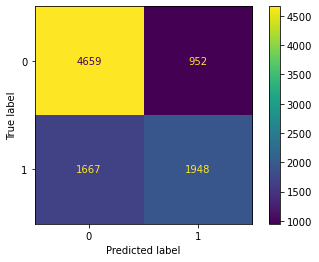

In [35]:
# plot the confusion matrix of the model
plot_confusion_matrix(reg_model, X_test, y_test)

**Interpretation:** There are 4659 correct predictions of the class 0 for churn;the false predictions of the class 0 is 952. The number of the accurate class 1 values for churn is 1948, while the false positive (inaccurate class 1 prediction in this case) is 1667. As such, we could see the correct prediction have been improved (4659+1948 true case (current) compared to 4580+1881 true case (previous)), and the false also decrease. However, this model might still not predict the class 1 for the churn precisely since the false positive value is still high.

### Feature Selection:

In [36]:
# check the column in the train set
X_train.shape

(36901, 19)

In [37]:
# list for containing all the accuracy score
acc_scores = []

print("The accuracy score of the model:")
for i in range(1, 20):
    # build and fit the model
    new_lr = LogisticRegression(max_iter = 1000)
    new_rfe = RFE(estimator = new_lr, n_features_to_select = i, step = 1)
    new_rfe.fit(X_train, y_train)
    # predict based on test set
    new_preds = new_rfe.predict(X_test)
    # calculate accuracy score and append to the list
    new_acc_score = accuracy_score(y_test, new_preds)
    acc_scores.append(new_acc_score)
    # print the number of features with the accuracy score
    print("- with selection of", i, "features: ", new_acc_score)

The accuracy score of the model:
- with selection of 1 features:  0.6375460654671581
- with selection of 2 features:  0.6552135269889443
- with selection of 3 features:  0.6519618469542597
- with selection of 4 features:  0.6519618469542597
- with selection of 5 features:  0.6519618469542597
- with selection of 6 features:  0.6536960763060915
- with selection of 7 features:  0.6536960763060915
- with selection of 8 features:  0.6536960763060915
- with selection of 9 features:  0.6547799696509864
- with selection of 10 features:  0.6708215911554303
- with selection of 11 features:  0.6736397138521569
- with selection of 12 features:  0.6723390418382831
- with selection of 13 features:  0.7108172555820508
- with selection of 14 features:  0.7115759809234772
- with selection of 15 features:  0.7134185996097984
- with selection of 16 features:  0.7139605462822458
- with selection of 17 features:  0.716236722306525
- with selection of 18 features:  0.7163451116410146
- with selection of 19 

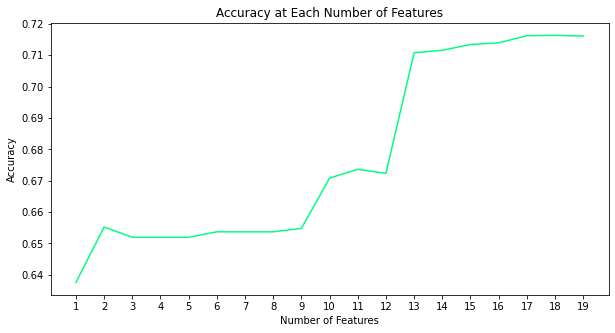

In [38]:
# Plotting the accuracy number
plt.figure(figsize=(10,5))
plt.plot(range(1, X_train.shape[1]+1), acc_scores, color= "springgreen")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.title("Accuracy at Each Number of Features")
plt.xticks(np.arange(1, 20, step=1))
plt.show()

**Interpretation:** We could see the accuracy score of seventeen-features model is slightly higher than (not much different from) the nineteen-features model (0.7162 compared to 0.7161). Therefore, we could build the model based on the seventeen most important features instead of choosing all of the nineteen features to build.

In [39]:
# re-build the model by selecting 17 features
svt_lr = LogisticRegression(max_iter = 1000)
svt_rfe = RFE(estimator = svt_lr, n_features_to_select = 17, step = 1)
svt_rfe.fit(X_train, y_train)

RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=17)

In [40]:
# check which 17 features have been selected
X_train.columns[svt_rfe.support_]

Index(['ACCOUNT_TENURE', 'AGE', 'SERVICE_TENURE', 'PLAN_ACCESS_FEE',
       'PLAN_TENURE', 'MONTHS_OF_CONTRACT_REMAINING',
       'LAST_FX_CONTRACT_DURATION', 'PREV_CONTRACT_DURATION', 'MONTHLY_SPEND',
       'CFU_CONSUMER', 'CFU_SMALL BUSINESS', 'BYO_PLAN_STATUS_BYO',
       'BYO_PLAN_STATUS_NON BYO', 'CONTRACT_STATUS_NO-CONTRACT',
       'CONTRACT_STATUS_OFF-CONTRACT', 'CONTRACT_STATUS_ON-CONTRACT',
       'COUNTRY_METRO_REGION_COUNTRY'],
      dtype='object')

**Comment:** The two features which have not been selected are `ACCT_CNT_SERVICES` and `COUNTRY_METRO_REGION_METRO` (`COUNTRY_METRO_REGION`). Since `COUNTRY_METRO_REGION_COUNTRY` is included in the model, we will try to exclude this feature (since the `METRO` is not included, and they are actually in the same field) and re-check the accuracy score for the model with 16 features only.

In [41]:
# try the temporary model by selecting 16 features
temp_lr = LogisticRegression(max_iter = 1000)
temp_train = X_train.drop(["COUNTRY_METRO_REGION_COUNTRY", "ACCT_CNT_SERVICES",
                           "COUNTRY_METRO_REGION_METRO"], axis=1)
temp_test = X_test.drop(["COUNTRY_METRO_REGION_COUNTRY", "ACCT_CNT_SERVICES",
                           "COUNTRY_METRO_REGION_METRO"], axis=1)
print(temp_train.shape)
temp_lr.fit(temp_train, y_train)

(36901, 16)


LogisticRegression(max_iter=1000)

In [42]:
# fit in input of train and test set
temp_train_preds = temp_lr.predict(temp_train)
temp_test_preds = temp_lr.predict(temp_test)

In [43]:
# check the accuracy of the model
print("Temporary train accuracy:")
print(accuracy_score(y_train, temp_train_preds))

print("Temporary test accuracy:")
print(accuracy_score(y_test, temp_test_preds))

Temporary train accuracy:
0.7267282729465326
Temporary test accuracy:
0.7149360502926512


**Comment:** The accuracy score is not much different from the model with 17 features (0.7149 v.s. 0.7162), and higher than the model with five features (0.71494 v.s. 0.69998). Thus, we could choose this 16 features model as the best model for this dataset. The accuracy scores for train and test sets indicate the model is not overfitting.

**Final chosen fields (not in dummy):** `ACCOUNT_TENURE`, `AGE`, `SERVICE_TENURE`, `PLAN_ACCESS_FEE`, `PLAN_TENURE`, `MONTHS_OF_CONTRACT_REMAINING`,`LAST_FX_CONTRACT_DURATION`, `PREV_CONTRACT_DURATION`,`MONTHLY_SPEND`, `CFU`, `BYO_PLAN_STATUS`, `CONTRACT_STATUS`.